In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

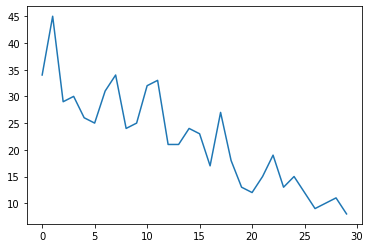

In [2]:
num_timesteps = 30
observed_counts = np.round(3 + np.random.lognormal(np.log(np.linspace(
    num_timesteps, 5, num=num_timesteps)), 0.20, size=num_timesteps)) 
observed_counts = observed_counts.astype(np.float32)
plt.plot(observed_counts);

In [3]:
def build_model(approximate_unconstrained_rates):
  trend = tfp.sts.LocalLinearTrend(observed_time_series=approximate_unconstrained_rates)
  return tfp.sts.Sum(
    [trend],
    observed_time_series=approximate_unconstrained_rates
  )

In [4]:
positive_bijector = tfb.Softplus()

approximate_unconstrained_rates = positive_bijector.inverse(
  tf.convert_to_tensor(observed_counts) + 1e-2
)

sts_model = build_model(approximate_unconstrained_rates)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


In [6]:
Root = tfd.JointDistributionCoroutine.Root

def sts_with_possion_likelihood_model():
  param_vals = []
  for param in sts_model.parameters:
    param_val = yield Root(param.prior)
    param_vals.append(param_val)
    
  unconstrained_rate = yield sts_model.make_state_space_model(
    num_timesteps,
    param_vals
  )
  rate = positive_bijector.forward(unconstrained_rate[..., 0])
  observed_counts = yield tfd.Independent(tfd.Poisson(rate), reinterpreted_batch_ndims=1)
  
model = tfd.JointDistributionCoroutine(sts_with_possion_likelihood_model)

In [7]:
# Condition a joint log-prob on the observed counts.
target_log_prob_fn = lambda *args: model.log_prob(args + (observed_counts,))

In [8]:
constraining_bijectors = ([param.bijector for param in sts_model.parameters] +
                           # `unconstrained_rate` is already unconstrained, but
                           # we can speed up inference by rescaling it.
                           [tfb.Scale(positive_bijector.inverse(
                               np.float32(np.max(observed_counts / 5.))))])

In [9]:
# Allow external control of sampling to reduce test runtimes.
num_results = 100 # @param { isTemplate: true}
num_results = int(num_results)

num_burnin_steps = 50 # @param { isTemplate: true}
num_burnin_steps = int(num_burnin_steps)

In [10]:
sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.1),
    bijector=constraining_bijectors)

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=0.75,
    # NUTS inside of a TTK requires custom getter/setter functions.
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
        inner_results=pkr.inner_results._replace(step_size=new_step_size)
        ),
    step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
)

initial_state = [b.forward(tf.random.normal(part_shape))
                 for (b, part_shape) in zip(
                     constraining_bijectors, model.event_shape[:-1])]

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.


In [11]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, experimental_compile=True)
def do_sampling():
  return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps)

t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Inference ran in 16.72s.


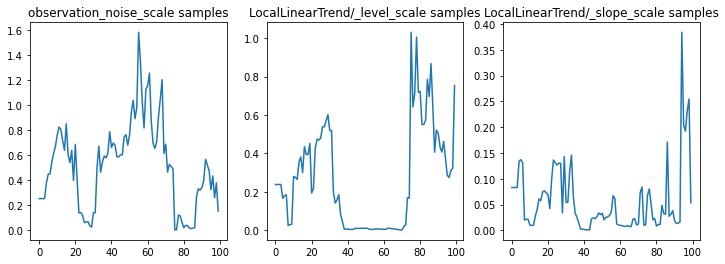

In [12]:
f = plt.figure(figsize=(12, 4))
for i, param in enumerate(sts_model.parameters):
  ax = f.add_subplot(1, len(sts_model.parameters), i + 1)
  ax.plot(samples[i])
  ax.set_title("{} samples".format(param.name))